In [7]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Force CPU for this example
print(f"Using device: {device}")

Using device: cuda


## Performance Comparison

In [8]:
def create_networks(input_size, hidden_size, output_size):
    """
    Create all network variants for comparison
    """
    L1 = nn.Linear(input_size, hidden_size)
    L2 = nn.Linear(hidden_size, output_size)

    # Create Sequential network
    seq_net = nn.Sequential(
        L1,
        nn.ReLU(),
        L2
    ).to(device)
    
    # Create equivalent Sequential2D network
    in_features_list = [input_size, hidden_size, output_size]
    out_features_list = [input_size, hidden_size, output_size]
    I = Identity(in_features=input_size, out_features=input_size)
    sigmaL2 = Sequential1D(nn.Sequential(nn.ReLU(), L2), 
                           in_features=hidden_size, out_features=output_size)
    blocks = [
        [None,    L1,   None],
        [None, None, sigmaL2],
        [None, None, None]
    ]
    seq2d_net = Sequential2D(in_features_list, out_features_list, blocks).to(device)
    
    # You can add more network variants here like:
    class Unpacked2DNetwork(nn.Module):
        def __init__(self, L1, L2):
            super(Unpacked2DNetwork, self).__init__()
            self.L1 = L1
            self.L2 = L2

        def forward(self, x):
            x = self.L1(x)
            x = nn.ReLU()(x)
            x = self.L2(x)
            return x

    seq_unpacked2d_net = Unpacked2DNetwork(L1, L2).to(device)

    return {
        'seq_net': seq_net,
        'seq2d_net': seq2d_net,
        'seq_unpacked2d_net': seq_unpacked2d_net,  
    }

def benchmark_network(network, test_input, network_type, iterations=100):
    """
    Benchmark a single network
    """
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()
    
    for _ in range(iterations):
        with torch.no_grad():
            if network_type == "seq_net":
                output = network(test_input)
            elif network_type == "seq2d_net":
                x = [test_input, None, None]
                for i in range(2):
                    x = network(x)
                output = x
            elif network_type == "seq_unpacked2d_net":
                output = network(test_input)
            else:
                # Generic fallback for any other network types
                output = network(test_input)
    
    torch.cuda.synchronize() if device.type == 'cuda' else None
    return time.time() - start_time

def benchmark_networks():
    """
    Benchmark computational performance of Sequential vs Sequential2D
    """
    # Test different network sizes
    sizes = [
        (256, 128, 64),
        (512, 256, 128), 
        (1024, 512, 256),
        (2048, 1024, 512),
        (4096, 2048, 1024),
        (8192, 4096, 2048), 
        (16384, 8192, 4096)  
    ]
    
    results = []
    
    for input_size, hidden_size, output_size in sizes:
        print(f"\nTesting size: {input_size} -> {hidden_size} -> {output_size}")
        
        # Create all network variants
        networks = create_networks(input_size, hidden_size, output_size)
        
        # Create test data
        batch_size = 64
        test_input = torch.randn(batch_size, input_size).to(device)
        
        # Test equivalence across all networks
        with torch.no_grad():
            # Get outputs from all networks
            outputs = {}
            
            # Sequential network (reference)
            outputs['seq_net'] = networks['seq_net'](test_input)
            
            # Sequential2D network 
            x = [test_input, None, None]
            for i in range(2):
                x = networks['seq2d_net'](x)
            outputs['seq2d_net'] = x[2]  # Final output
            
            # Almost2D network
            outputs['seq_unpacked2d_net'] = networks['seq_unpacked2d_net'](test_input)
            
            # Test equivalence of all networks against the reference (seq_net)
            reference_output = outputs['seq_net']
            print("Equivalence testing:")
            
            for net_name, output in outputs.items():
                if net_name != 'seq_net':
                    max_diff = torch.max(torch.abs(reference_output - output)).item()
                    is_equivalent = max_diff < 1e-6
                    print(f"  {net_name} vs seq_net: max_diff={max_diff:.2e}, equivalent={is_equivalent}")
                    
                    if not is_equivalent:
                        print(f"    Warning: {net_name} output differs significantly from seq_net!")
        
        # Benchmark each network
        result = {'input_size': input_size}
        
        for net_name, network in networks.items():
            time_taken = benchmark_network(network, test_input, net_name)
            result[f'{net_name}_time'] = time_taken
            result[f'{net_name}_params'] = sum(p.numel() for p in network.parameters())
            print(f"{net_name} time: {time_taken:.4f}s")
        
        # Calculate speedups relative to seq_net
        if 'seq_net_time' in result:
            for net_name in networks.keys():
                if net_name != 'seq_net':
                    speedup = result['seq_net_time'] / result[f'{net_name}_time']
                    result[f'{net_name}_speedup'] = speedup
                    print(f"{net_name} speedup: {speedup:.2f}x")
        
        results.append(result)
    
    return pd.DataFrame(results)

# Run benchmarks
benchmark_results = benchmark_networks()
print("\nBenchmark Results:")
print(benchmark_results)


Testing size: 256 -> 128 -> 64
Equivalence testing:
  seq2d_net vs seq_net: max_diff=0.00e+00, equivalent=True
  seq_unpacked2d_net vs seq_net: max_diff=0.00e+00, equivalent=True
seq_net time: 0.0049s
seq2d_net time: 0.0081s
seq_unpacked2d_net time: 0.0078s
seq2d_net speedup: 0.61x
seq_unpacked2d_net speedup: 0.63x

Testing size: 512 -> 256 -> 128
Equivalence testing:
  seq2d_net vs seq_net: max_diff=0.00e+00, equivalent=True
  seq_unpacked2d_net vs seq_net: max_diff=0.00e+00, equivalent=True
seq_net time: 0.0066s
seq2d_net time: 0.0111s
seq_unpacked2d_net time: 0.0065s
seq2d_net speedup: 0.59x
seq_unpacked2d_net speedup: 1.01x

Testing size: 1024 -> 512 -> 256
Equivalence testing:
  seq2d_net vs seq_net: max_diff=0.00e+00, equivalent=True
  seq_unpacked2d_net vs seq_net: max_diff=0.00e+00, equivalent=True
seq_net time: 0.0049s
seq2d_net time: 0.0077s
seq_unpacked2d_net time: 0.0059s
seq2d_net speedup: 0.63x
seq_unpacked2d_net speedup: 0.83x

Testing size: 2048 -> 1024 -> 512
Equivale

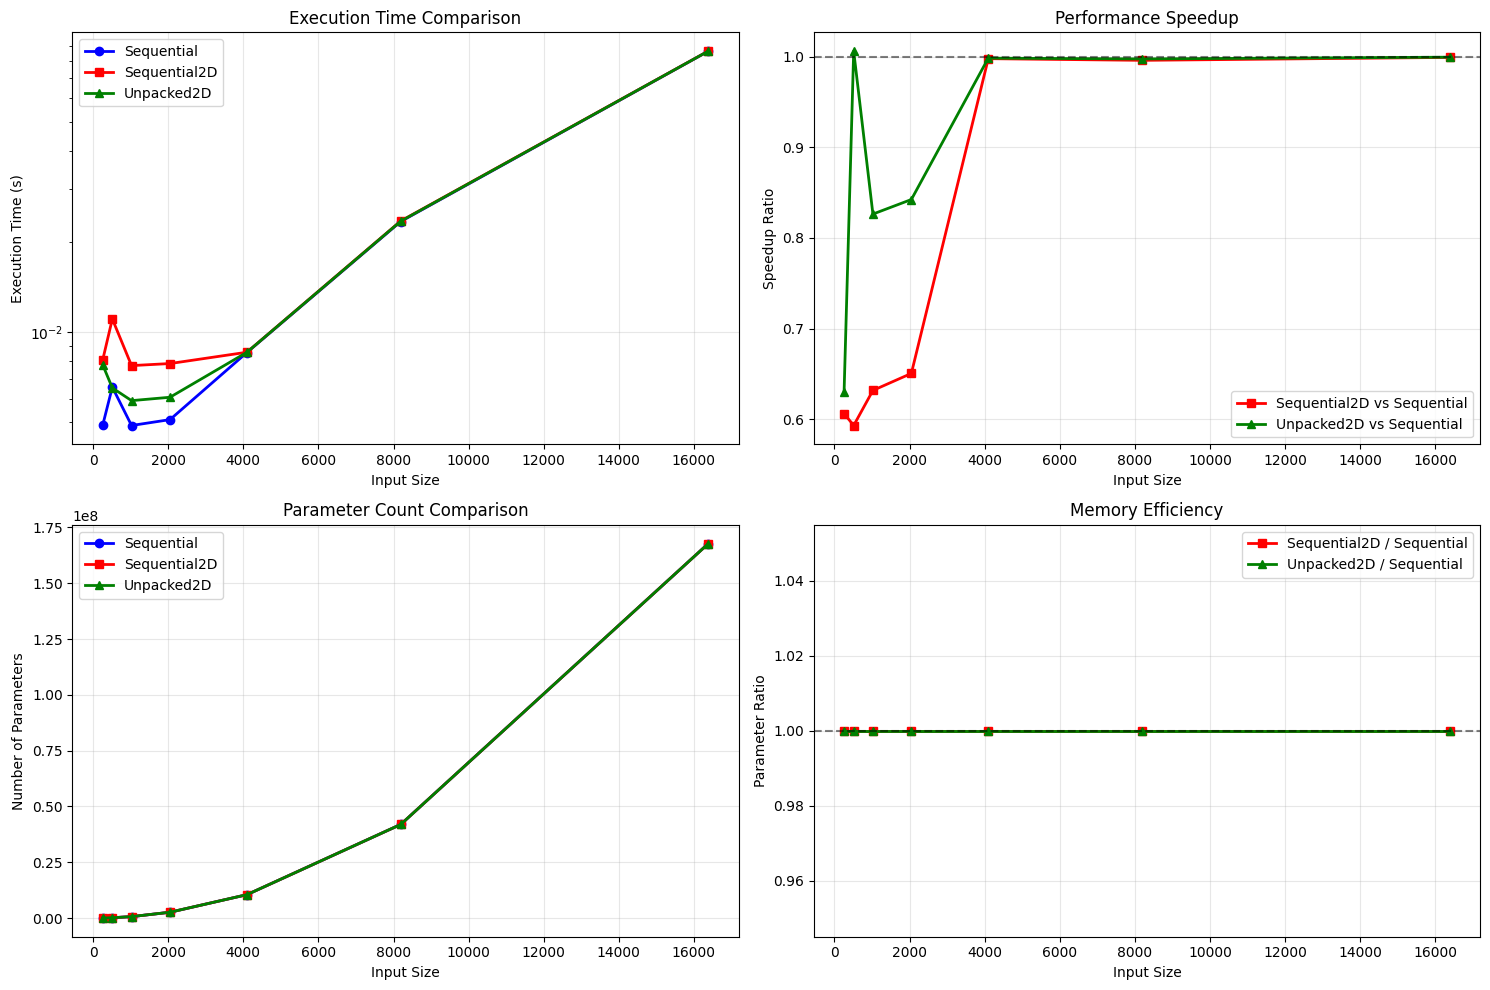

In [ ]:
def plot_performance_comparison():
    """
    Visualize performance comparison results
    """
    # Automatically detect network types from benchmark results
    time_columns = [col for col in benchmark_results.columns if col.endswith('_time')]
    network_names = [col.replace('_time', '') for col in time_columns]
    param_columns = [col for col in benchmark_results.columns if col.endswith('_params')]
    speedup_columns = [col for col in benchmark_results.columns if col.endswith('_speedup')]
    
    # Create nice display names
    display_names = {
        'seq_net': 'Sequential',
        'seq2d_net': 'Sequential2D',
        'seq_unpacked2d_net': 'Unpacked2D'  
    }
    
    # Color and marker cycles for multiple networks
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    markers = ['o', 's', '^', 'd', 'v', 'p']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Execution time comparison
    for i, (net_name, time_col) in enumerate(zip(network_names, time_columns)):
        label = display_names.get(net_name, net_name.replace('_', ' ').title())
        ax1.semilogy(benchmark_results['input_size'], benchmark_results[time_col], 
                color=colors[i % len(colors)], marker=markers[i % len(markers)],
                label=label, linewidth=2, markersize=6)
    ax1.set_xlabel('Input Size')
    ax1.set_ylabel('Log of Execution Time (s)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Speedup (relative to first network, typically seq_net)
    if speedup_columns:
        for i, speedup_col in enumerate(speedup_columns):
            net_name = speedup_col.replace('_speedup', '')
            label = display_names.get(net_name, net_name.replace('_', ' ').title())
            ax2.plot(benchmark_results['input_size'], benchmark_results[speedup_col], 
                    color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)],
                    label=f'{label} vs {display_names.get(network_names[0], network_names[0])}', 
                    linewidth=2, markersize=6)
        ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Input Size')
        ax2.set_ylabel('Speedup Ratio')
        ax2.set_title('Performance Speedup')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No speedup data available', 
                transform=ax2.transAxes, ha='center', va='center')
        ax2.set_title('Performance Speedup')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Parameter count comparison
    for i, (net_name, param_col) in enumerate(zip(network_names, param_columns)):
        label = display_names.get(net_name, net_name.replace('_', ' ').title())
        ax3.plot(benchmark_results['input_size'], benchmark_results[param_col], 
                color=colors[i % len(colors)], marker=markers[i % len(markers)],
                label=label, linewidth=2, markersize=6)
    ax3.set_xlabel('Input Size')
    ax3.set_ylabel('Number of Parameters')
    ax3.set_title('Parameter Count Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Memory efficiency (ratio relative to first network)
    if len(param_columns) >= 2:
        base_params = benchmark_results[param_columns[0]]  # Use first network as baseline
        for i, param_col in enumerate(param_columns[1:], 1):
            net_name = param_col.replace('_params', '')
            label = display_names.get(net_name, net_name.replace('_', ' ').title())
            memory_ratio = benchmark_results[param_col] / base_params
            ax4.plot(benchmark_results['input_size'], memory_ratio, 
                    color=colors[i % len(colors)], marker=markers[i % len(markers)],
                    label=f'{label} / {display_names.get(network_names[0], network_names[0])}', 
                    linewidth=2, markersize=6)
        ax4.axhline(y=1, color='k', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Input Size')
        ax4.set_ylabel('Parameter Ratio')
        ax4.set_title('Memory Efficiency')
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Need multiple networks for comparison', 
                transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title('Memory Efficiency')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_performance_comparison()